Code for **"Linear Comp. Sensing"** 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
from utils.inpainting_utils import *
from utils.utils import *

# Misc. Setup

In [2]:
# Enable GPU usage
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Change cwd
directory = "/home/justin/Github/deep-image-prior/"
os.chdir(directory)

# Misc.
PLOT = True
imsize = -1
dim_div_by = 64

# Load MNIST

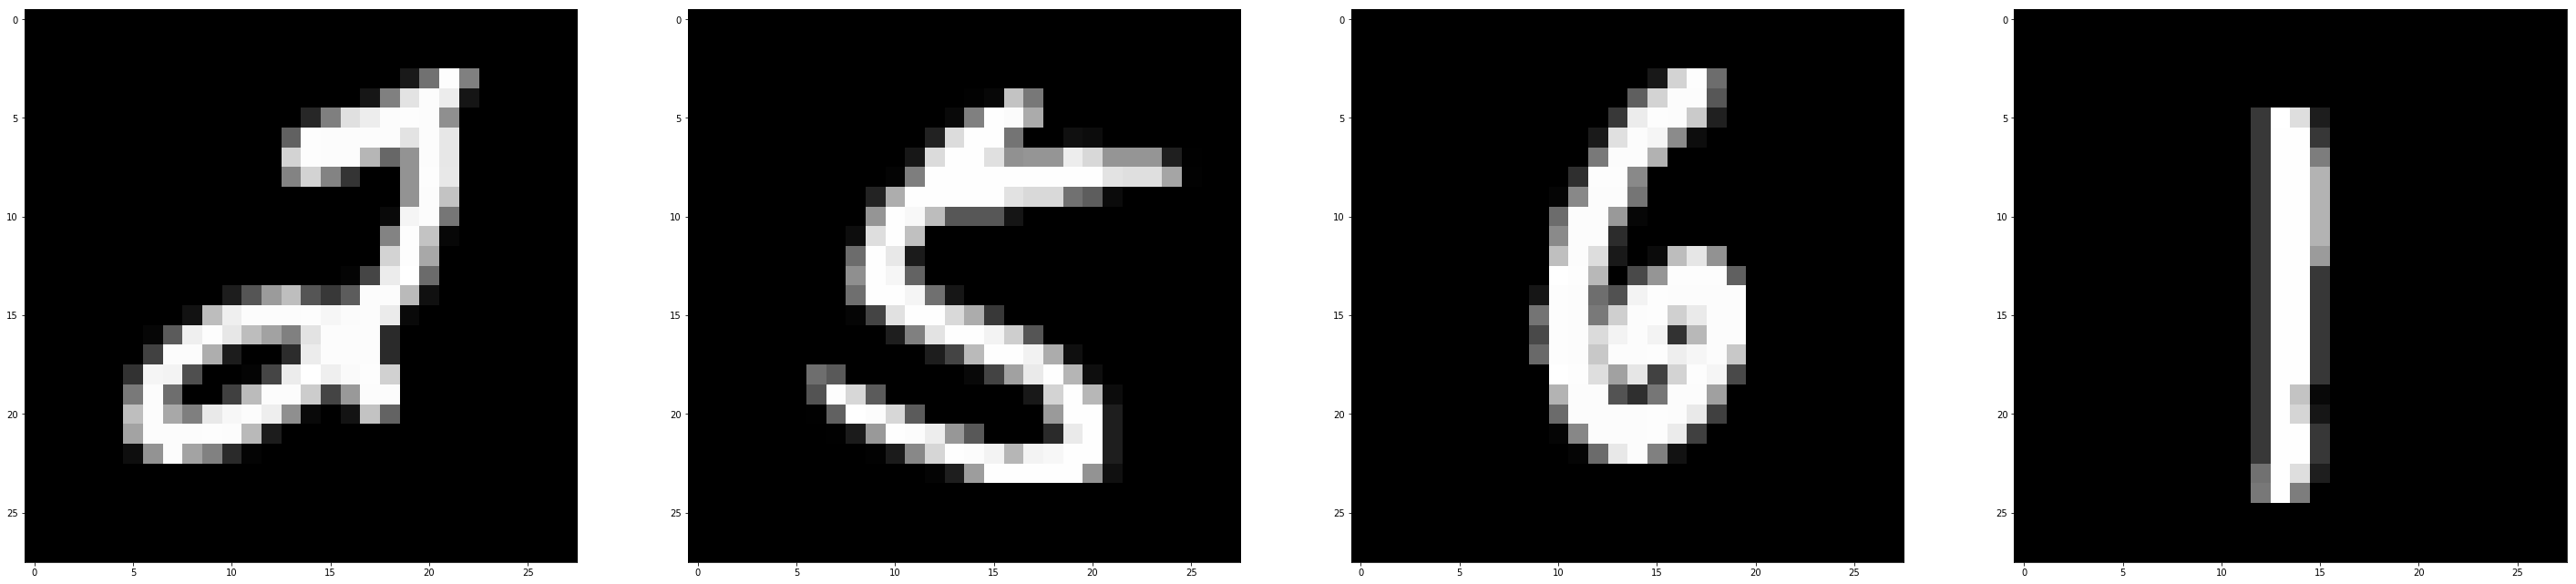

In [3]:
mnist_arrays, mnist_labels, _, _ = MNIST_load()
mnist_shape = [28,28]

# Plot some examples
fig = plt.figure(figsize=(50,50))

num_images = 4
for i in range(num_images):
    sub = fig.add_subplot(1,num_images, i + 1)
    array = mnist_arrays[i,:]
    image = np.reshape(array,newshape=mnist_shape)
    sub.imshow(image, cmap='gray')

In [4]:
# Save MNIST data to matlab

from scipy.io import savemat
mnist_arrays = mnist_arrays[0:4]
dir = "/home/justin/Github/phasepack-matlab/data/MNIST/"

for i, array in enumerate(mnist_arrays):
    filename = dir+"mnist"+str(i)+".mat"
    array = np.ndarray.tolist(array)
    my_dict = {'vect':array}
    savemat(filename, my_dict)

# Create Test Measurements

In [5]:
# # Generate Gaussian Matrix (A)
# m = 28*14
# n = 28*28
# mu = 0.0
# sigma = 0.25

# A = mu + sigma*np.random.randn(m,n)

# # Create Measurements (y = |A*x|)
# measurements = np.zeros([0,m])
# num_examples = 10

# for image_array in mnist_arrays[0:num_examples]:
#     measurement = [np.matmul(A,image_array)]
#     measurements = np.vstack([measurements,measurement])

# Load Image and Measurement

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


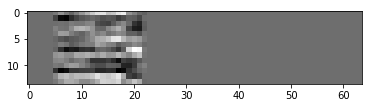

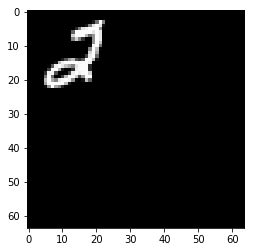

In [29]:
#----------------------------------------------------------------
# "Natural Image" Example
#--------

# # Set Image
# img_type = 'grayscale'
# img_path  = 'data/inpainting/vase.png'
# _, img_np = get_image(img_path, imsize, img_type)

# # Print Image
# plt.imshow(img_np[0], cmap = 'gray')
# plt.show()

# # Generate Gaussian Matrix (A)
# m = int(float(np.shape(img_np)[1])/2.0)
# n = np.shape(img_np)[1]
# mu = 0.0
# sigma = 0.25

# A = mu + sigma*np.random.randn(m,1,n)
# A_var = np_to_torch(A, False).type(dtype)

# # Set Measurement
# measurement = np.tensordot(A,img_np,2)
# measurement_var = np_to_torch(measurement, False).type(dtype)

#----------------------------------------------------------------
# MNIST Example
#--------

# Set Image
value = 0
img_array = mnist_arrays[value]
img_np = np.reshape(img_array,np.hstack([1, mnist_shape]))
pad_shape = [64,64]
img_np = pad_zeros(img_np[0],pad_shape).reshape([1]+pad_shape)
img_var = np_to_torch(img_np).type(dtype)

# Generate Gaussian Matrix (A)
n = np.shape(img_np)[1]
m = int(mnist_shape[0]/2.0)
mu = 0.0
sigma = 1/m

A = mu + sigma*np.random.randn(m,1,n)
A_var = np_to_torch(A).type(dtype)

# Set Measurement
measurement = np.tensordot(A,img_np)
measurement_var = np_to_torch(measurement).type(dtype)
plt.imshow(measurement,cmap='gray')
plt.show()

# Print Image
plt.imshow(img_np[0], cmap = 'gray')
plt.show()

# Setup

In [7]:
# Optimization Setup
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet


#--------------------------
# Network Arch. Setup
#--------------------
INPUT = 'meshgrid'
input_depth = 2                   # depth of input noise
output_depth = 1
LR = 0.01                         # learning rate
num_iter = 1300
param_noise = False               # add noise to net params during optimization 
show_every = 100
figsize = 5
reg_noise_std = 0.03              # add noise to net input during optimization

num1 = 5 # 5
num2 = 3 # 3
num3 = 128 # 128

net = skip(input_depth, output_depth, 
           num_channels_down = [num3] * num1,
           num_channels_up   = [num3] * num1,
           num_channels_skip = [0] * num1,  
           upsample_mode='nearest', filter_skip_size=1, filter_size_up=num2, filter_size_down=num2,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


net = net.type(dtype)
img_dim = img_np.shape[1:]
net_input = get_noise(input_depth, INPUT, img_dim).type(dtype)
#--------------------------

# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 2157697


# Main loop

Starting optimization with ADAM


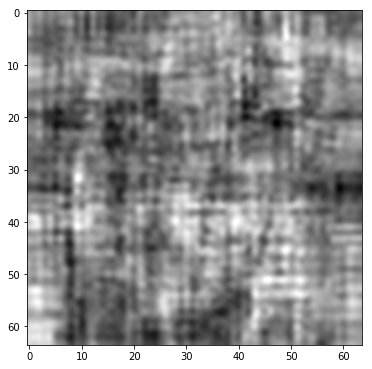

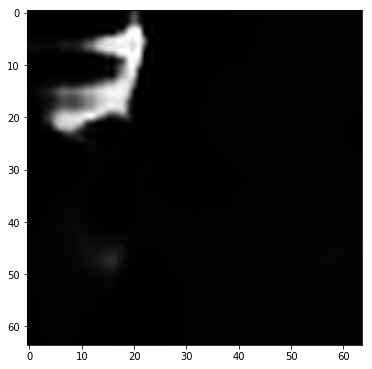

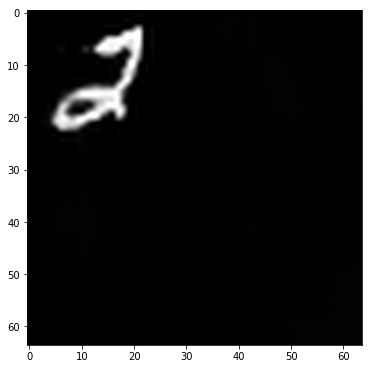

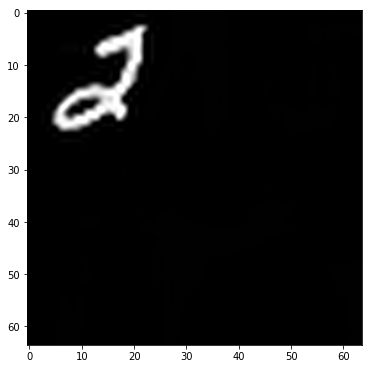

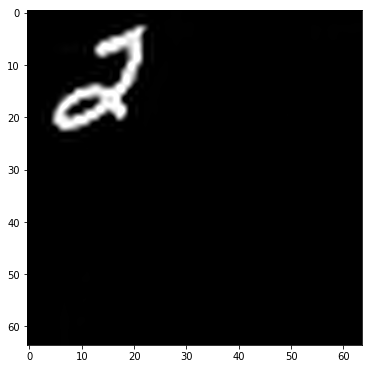

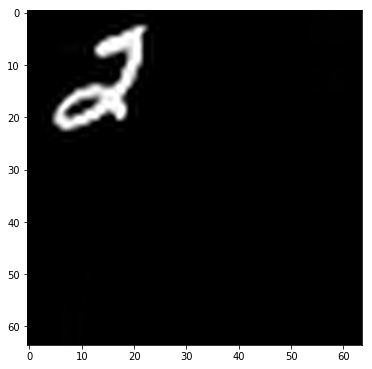

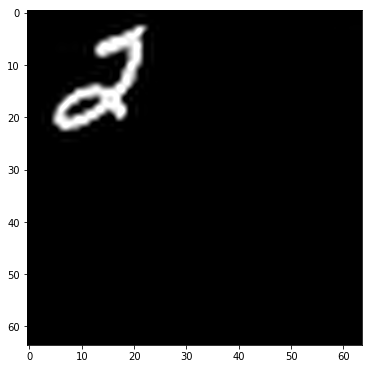

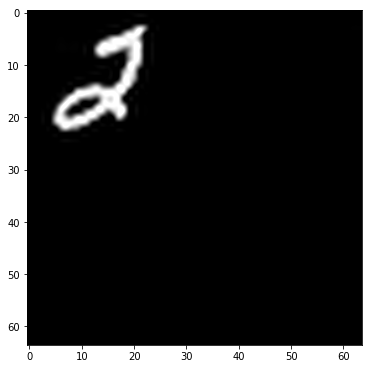

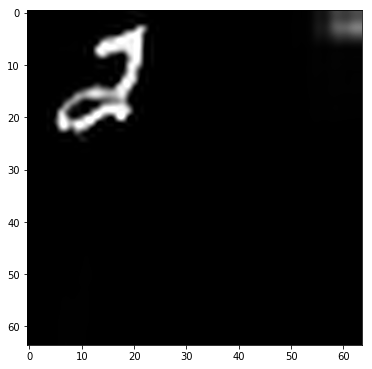

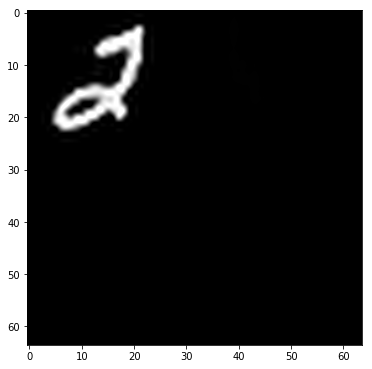

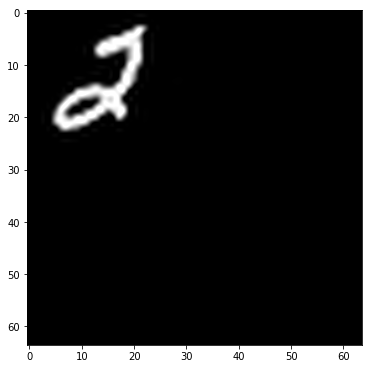

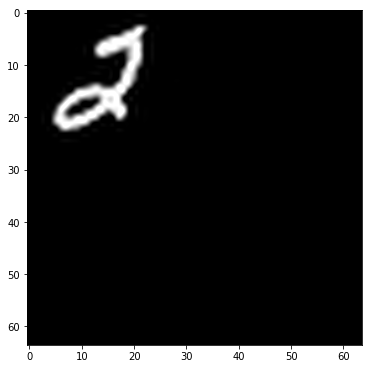

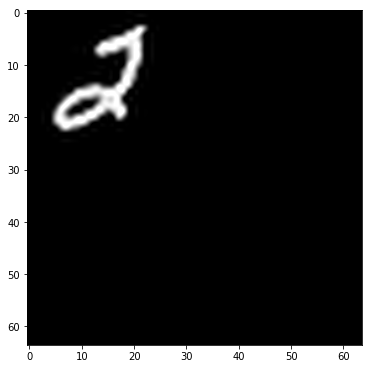

In [8]:
i = 0

#----------------------------------
def dip_function():

    global i
    
    # Add noise to network parameters / network input
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
            
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    net_input_np = torch_to_np(net_input)
    
    # Output of network
    out = net(net_input)   
    out_np = torch_to_np(out)
    
    # Calculate measurement estimate |A*net_out|
    new_shape = tuple(out.shape[1:])    # eliminate unnecessary dimension
    out = out.view(new_shape)           # must reshape before tensordot
    measurement_hat = tensordot_pytorch(A_var,out,axes=2)
    
    # Define Loss (||A*net_out|-|A*image||l2)
    total_loss = mse(measurement_hat, measurement_var)
    total_loss.backward()
    total_loss_img = mse(measurement_hat, measurement_var)
    
    # Print Progress
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        
        dir_ = "./plots/lin_comp_sense/"
        name = "reconst_iter: "+str(i)+".png"
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize,
                        nrow=1, save=True, directory=dir_, filename=name)
        
    i += 1
    return total_loss

#----------------------------------

# Final Setup
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Optimize
p = get_params(OPT_OVER, net, net_input)
losses = optimize(OPTIMIZER, p, dip_function, LR, num_iter)

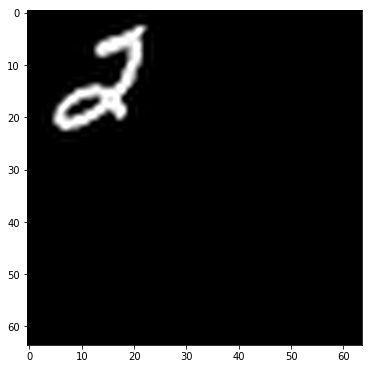

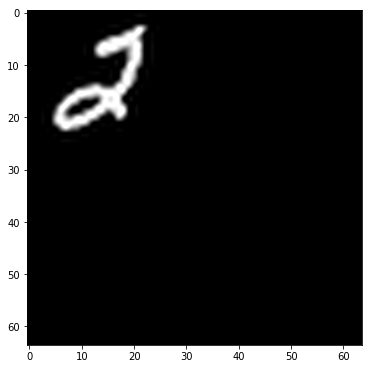

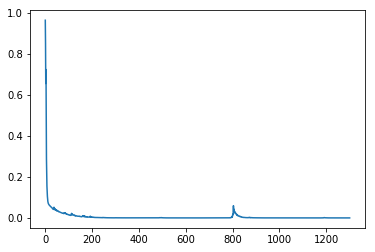

In [32]:
# Plot Final Estimate
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);
plot_image_grid([img_np], factor=5);

# Plot Loss vs Iteration
plt.plot(np.arange(1,num_iter+1),losses)
directory = "./plots/lin_comp_sense/"
plt.savefig(directory+'loss vs iteration')
plt.show()

In [10]:
# Save Data 

import pickle
my_object = losses
filename = directory + "losses.obj"

with open(filename, 'wb') as fp:
    pickle.dump(my_object, fp)

In [12]:
# # Plot Measurements

# print(measurement_var.shape)
# plt.imshow(measurement_var, cmap = 'gray')
# plt.savefig(directory+'measurement')
# plt.show()